# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="../Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. training agents

In [5]:
from ddpg_agent import Agent

agent = Agent(
    state_size=state_size,
    action_size=action_size,
    random_seed=0,
)

n_episodes = 2000
epsilon_decay = 0.9995
epsilon_min = 0.01
epsilon = 1

In [6]:
score_history = []
smoothed_score_history = []
time_for_each_episode = []
for i in range(1, n_episodes):
    start = time.time()
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    agent.reset()
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        epsilon *= epsilon_decay
        if np.random.uniform()<max(epsilon, epsilon_min):
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        else:
            actions = [agent.act(states[0:1,:]), agent.act(states[1:,:])]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent.step(state, action, reward, next_state, done)
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    score_history.append(np.max(scores))
    n_valid_scores = min(len(score_history), 100)
    smoothed_score_history.append(sum(score_history[-n_valid_scores:])/n_valid_scores)
    time_for_each_episode.append(time.time()-start)
    if i%10==0:
        print(f'Score (max over agents) from episode {i}: '
              f'{score_history[-1]:.5f} / {smoothed_score_history[-1]:.5f} ' 
              f'({time_for_each_episode[-1]:.3f} s, buf_size={len(agent.memory)}, epsilon={epsilon:.5f})')
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if smoothed_score_history[-1]>1:
        break

/Users/maeday/work/udacity/rl/p3/p3_submission/ddpg_agent.py:108: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Score (max over agents) from episode 10: 0.00000 / 0.01800 (0.583 s, buf_size=350, epsilon=0.91620)
Score (max over agents) from episode 20: 0.00000 / 0.01850 (0.444 s, buf_size=702, epsilon=0.83900)
Score (max over agents) from episode 30: 0.00000 / 0.01567 (0.469 s, buf_size=1052, epsilon=0.76869)
Score (max over agents) from episode 40: 0.09000 / 0.01400 (0.962 s, buf_size=1368, epsilon=0.71029)
Score (max over agents) from episode 50: 0.00000 / 0.01320 (0.480 s, buf_size=1692, epsilon=0.65501)
Score (max over agents) from episode 60: 0.09000 / 0.01567 (0.925 s, buf_size=2118, epsilon=0.58882)
Score (max over agents) from episode 70: 0.00000 / 0.01614 (0.470 s, buf_size=2542, epsilon=0.52959)
Score (max over agents) from episode 80: 0.00000 / 0.01650 (0.426 s, buf_size=2892, epsilon=0.48521)
Score (max over agents) from episode 90: 0.00000 / 0.01678 (0.447 s, buf_size=3242, epsilon=0.44455)
Score (max over agents) from episode 100: 0.09000 / 0.01690 (0.916 s, buf_size=3592, epsilon=

Score (max over agents) from episode 810: 0.10000 / 0.10290 (0.984 s, buf_size=34438, epsilon=0.00018)
Score (max over agents) from episode 820: 0.20000 / 0.10730 (2.663 s, buf_size=35360, epsilon=0.00014)
Score (max over agents) from episode 830: 0.10000 / 0.11280 (1.697 s, buf_size=36500, epsilon=0.00011)
Score (max over agents) from episode 840: 0.10000 / 0.11370 (0.941 s, buf_size=37350, epsilon=0.00009)
Score (max over agents) from episode 850: 0.09000 / 0.11730 (0.933 s, buf_size=38184, epsilon=0.00007)
Score (max over agents) from episode 860: 0.10000 / 0.11920 (0.997 s, buf_size=38914, epsilon=0.00006)
Score (max over agents) from episode 870: 0.10000 / 0.11850 (1.018 s, buf_size=39526, epsilon=0.00005)
Score (max over agents) from episode 880: 0.30000 / 0.12270 (3.314 s, buf_size=40610, epsilon=0.00004)
Score (max over agents) from episode 890: 0.20000 / 0.12770 (2.866 s, buf_size=41740, epsilon=0.00003)
Score (max over agents) from episode 900: 0.10000 / 0.12550 (0.992 s, buf

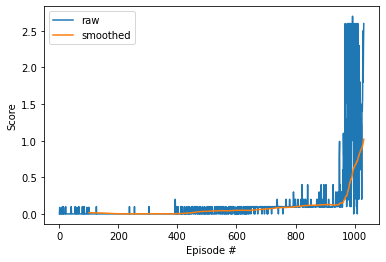

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
n_scores = len(score_history)
plt.plot(np.arange(1, n_scores+1), score_history, label="raw")
if n_scores>=100:
    plt.plot(
        np.arange(101, n_scores+1),
        smoothed_score_history[100:],
        label="smoothed",
    )
plt.plot()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [11]:
n_episodes = 10
#agent.load('checkpoint_actor.pth', 'checkpoint_critic.pth')
score_history = []
start = time.time()
time.sleep(5)
for i in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    agent.reset()
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = [agent.act(states[0:1,:]), agent.act(states[1:,:])]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
        time.sleep(0.01)
    score_history.append(np.max(scores))
    print(f'Score (max over agents) from episode {i}: {score_history[-1]:.5f} ' 
          f'({time.time()-start:.3f} s)')
    time.sleep(2)
print(f'mean score over {len(score_history)} : {sum(score_history)/len(score_history)}')

Score (max over agents) from episode 1: 0.10000 (5.852 s)
Score (max over agents) from episode 2: 2.60000 (24.332 s)
Score (max over agents) from episode 3: 0.10000 (26.711 s)
Score (max over agents) from episode 4: 2.60000 (45.279 s)
Score (max over agents) from episode 5: 0.20000 (48.299 s)
Score (max over agents) from episode 6: 2.60000 (66.609 s)
Score (max over agents) from episode 7: 0.00000 (68.667 s)
Score (max over agents) from episode 8: 2.10000 (84.070 s)
Score (max over agents) from episode 9: 2.60000 (102.545 s)
Score (max over agents) from episode 10: 2.60000 (121.095 s)
mean score over 10 : 1.5500000230967999
